In [1]:
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import DataLoader
import csv
import random
import numpy as np
import cv2
import mimetypes
import fnmatch
import seaborn as sns
from collections import Counter, defaultdict
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import time
from progress.bar import IncrementalBar
from tqdm.notebook import tqdm_notebook

In [2]:
pd.set_option('display.max_rows', None)
annotations_read = pd.read_csv('../Data/burnasyan_Br.csv', delimiter=',')
annotations_read

,IDX,Num,age,Dia,Dia2,biopsy,Grade,TNM,obj10_300,obj10_500,obj4_300,obj4_500
0,1,1,67.0,Papilloma,Benign,surgery,G0,NaN,83,37,26,10
1,2,2,66.0,Muc_CR,Invasive,biopsy,G1,pT2pN0,65,34,30,11
2,3,3,72.0,CR,Invasive,surgery,G1,pT1cpN0,503,207,142,61
3,4,3,72.0,CR,Invasive,surgery,G1,pT1cpN0,325,143,170,66
4,5,3,72.0,CR,Invasive,surgery,G1,pT1cpN0,646,262,90,35
5,6,4,43.0,FA,Benign,surgery,G0,NaN,355,167,138,69
6,7,5,71.0,CR,Invasive,surgery,G2,pT1cpN0,164,61,55,23
7,8,6,60.0,CR,Invasive,surgery,G2,pT2pN1a,328,138,122,52
8,9,6,60.0,CR,Invasive,surgery,G2,pT2pN1a,254,113,105,42
9,10,7,69.0,CR,Invasive,surgery,G2,pT1cpN0,122,52,28,12


### Checking the table for one-to-one correspondence with files

In [3]:
with open('../Data/burnasyan_Br.csv') as f:
    reader = list(csv.reader(f))
idx_list = np.array(reader)[1:, 0].astype(np.int32)
check_idx = np.arange(104) + 1
if any(idx_list != check_idx):
    print("Not one-to-one correspondence")

### Make a file with paths

In [4]:
f = open('paths.txt', 'w')
folder = []
for i in os.walk('../Data/burnasyan_Br'):
    folder.append(i)
for address, dirs, files in folder:
    for file in files:
        if mimetypes.guess_type(file)[0] == 'image/jpeg':
            f.write(os.path.join(address, file) + '\n') 
f.close()
with open('paths.txt', 'rb+') as filehandle:
    filehandle.seek(-1, os.SEEK_END)
    filehandle.truncate()


In [5]:
print(folder[0][1])

['82', '48', '49', '55', '60', '87', '34', '44', '30', '62', '71', '23', '35', '4', '20', '36', '32', '64', '39', '28', '53', '99', '80', '11', '85', '75', '26', '95', '2', '45', '67', '40', '66', '72', '91', '17', '16', '90', '65', '42', '1', '41', '88', '83', '104', '58', '29', '31', '5', '102', '92', '89', '81', '14', '98', '8', '94', '77', '93', '97', '7', '69', '3', '21', '68', '73', '57', '43', '9', '76', '38', '27', '13', '100', '18', '59', '63', '79', '24', '10', '19', '15', '101', '47', '74', '25', '46', '96', '54', '37', '52', '22', '78', '61', '70', '50', '6', '56', '86', '51', '84', '103', '33', '12']


### Checking the amount of images

In [6]:
number_of_imgs = np.array(reader)[1:, -4:].astype(np.int32)
number_of_imgs_real = np.empty_like(number_of_imgs)
dir_paths = []
for dir_i in folder[0][1]:
    dir_paths.append(os.path.join('../Data/burnasyan_Br/', dir_i))
dir_paths = np.array(dir_paths)
for dir_i in dir_paths:
    i = int(dir_i.split("/")[3]) - 1
    path = os.path.join(dir_i, 'ув10__300')
    number_of_imgs_real[i, 0] = len(fnmatch.filter(os.listdir(path), '*.jpg'))
    path = os.path.join(dir_i, 'ув10__500')
    number_of_imgs_real[i, 1] = len(fnmatch.filter(os.listdir(path), '*.jpg'))
    path = os.path.join(dir_i, 'ув4__300')
    number_of_imgs_real[i, 2] = len(fnmatch.filter(os.listdir(path), '*.jpg'))
    path = os.path.join(dir_i, 'ув4__500')
    number_of_imgs_real[i, 3] = len(fnmatch.filter(os.listdir(path), '*.jpg'))
print(np.nonzero(number_of_imgs - number_of_imgs_real))

(array([58]), array([0]))


In [7]:
print(number_of_imgs_real[58][0])

50


#### In folder 59 there are 50 (not 519) images

### Visualization of some data

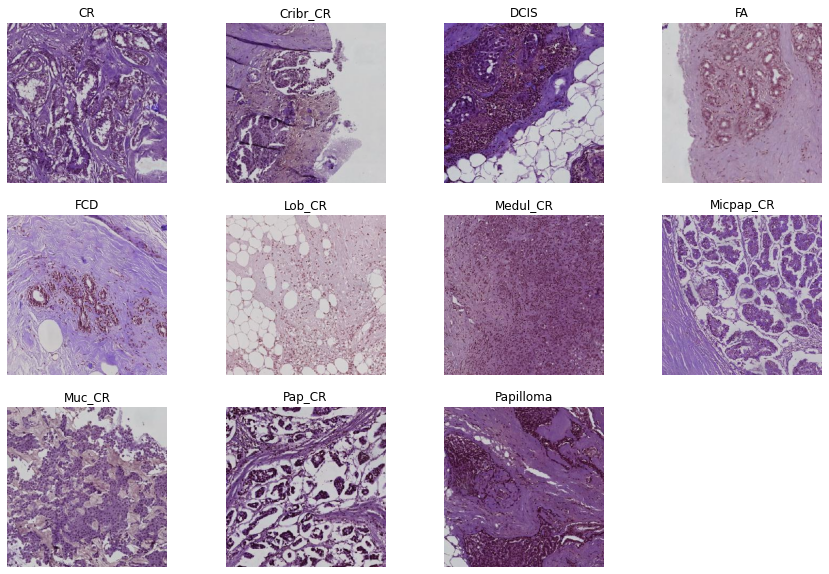

In [8]:
labels_map = {
    0: "CR",
    1: "Cribr_CR" ,
    2: "DCIS",
    3: "FA",
    4: "FCD",
    5: "Lob_CR",
    6: "Medul_CR",
    7: "Micpap_CR",
    8: "Muc_CR",
    9: "Pap_CR",
    10: "Papilloma",
}
dia_list = np.array(reader)[1:, 3]
# idx_list contains numbers of folders

figure = plt.figure(figsize=(15, 10))
cols, rows = 4, 3
for i in range(1, cols * rows):
    label = labels_map[i - 1]
    k = np.where(dia_list == label)
    path = os.path.join('../Data/burnasyan_Br/', str(idx_list[k][0]), 'ув4__300')
    path = os.path.join(path, fnmatch.filter(os.listdir(path), '*.jpg')[0])
    img = cv2.imread(path)
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze())
plt.show()

In [10]:
# кол-во папок
print(dia_list.shape)

### View Distributions

Распределение по категориям Dia

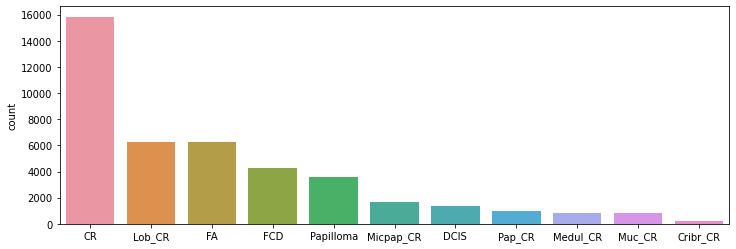

In [11]:
counts = defaultdict(int)
i = 0
for l in dia_list:
    counts[l] += int(np.sum(number_of_imgs_real[i].astype(np.int32), axis = 0))
    i += 1

counts_df = pd.DataFrame.from_dict(counts, orient='index')
counts_df.columns = ['count']
counts_df.sort_values('count', ascending=False, inplace=True)

fig, ax = plt.subplots()
ax = sns.barplot(x=counts_df.index, y=counts_df['count'], ax=ax)
fig.set_size_inches(12,4)
ax.set_xticklabels(ax.xaxis.get_majorticklabels())
None

По категориям Dia2

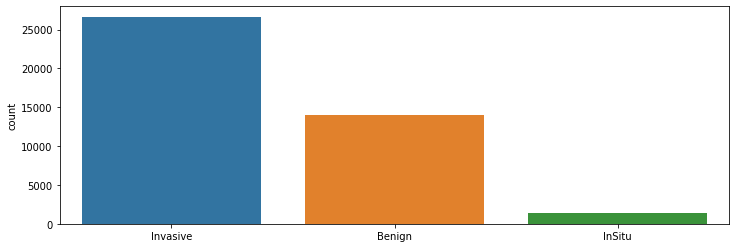

In [12]:
counts = defaultdict(int)
dia2_list = np.array(reader)[1:, 4]
i = 0
for l in dia2_list:
    counts[l] += int(np.sum(number_of_imgs_real[i].astype(np.int32), axis = 0))
    i += 1

counts_df = pd.DataFrame.from_dict(counts, orient='index')
counts_df.columns = ['count']
counts_df.sort_values('count', ascending=False, inplace=True)

fig, ax = plt.subplots()
ax = sns.barplot(x=counts_df.index, y=counts_df['count'], ax=ax)
fig.set_size_inches(12,4)
ax.set_xticklabels(ax.xaxis.get_majorticklabels())
None

In [13]:
print(counts)

defaultdict(<class 'int'>, {'Benign': 14032, 'Invasive': 26649, 'InSitu': 1358})


In [14]:
obj10_300 = np.sum(number_of_imgs_real[:,0].astype(np.int32), axis = 0)
obj10_500 = np.sum(number_of_imgs_real[:,1].astype(np.int32), axis = 0)
obj4_300 = np.sum(number_of_imgs_real[:,2].astype(np.int32), axis = 0)
obj4_500 = np.sum(number_of_imgs_real[:,3].astype(np.int32), axis = 0)

По размеру изображения

Amount of 300x300:  12939
Amount of 500x500:  29100


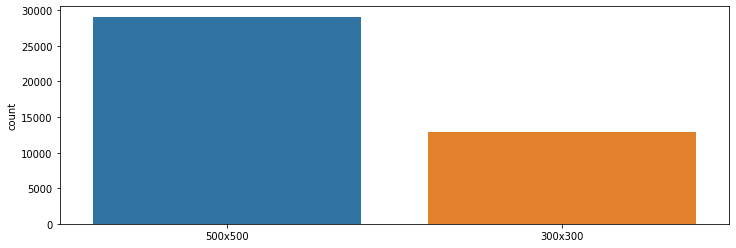

In [17]:
counts = defaultdict(int)
counts['300x300'] = obj4_500 + obj10_500
counts['500x500'] = obj10_300 + obj4_300
print('Amount of 300x300: ', counts['300x300'])
print('Amount of 500x500: ', counts['500x500'])

counts_df = pd.DataFrame.from_dict(counts, orient='index')
counts_df.columns = ['count']
counts_df.sort_values('count', ascending=False, inplace=True)

fig, ax = plt.subplots()
ax = sns.barplot(x=counts_df.index, y=counts_df['count'], ax=ax)
fig.set_size_inches(12,4)
ax.set_xticklabels(ax.xaxis.get_majorticklabels())
None

По увеличению

amount of x4:  9779
amount of x10:  32260


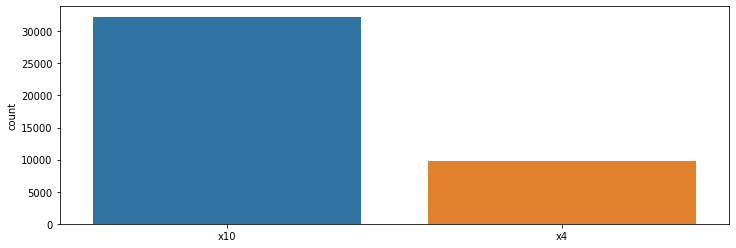

In [18]:
counts = defaultdict(int)
counts['x4'] = obj4_300 + obj4_500
counts['x10'] = obj10_300 + obj10_500
print('amount of x4: ', counts['x4'])
print('amount of x10: ', counts['x10'])

counts_df = pd.DataFrame.from_dict(counts, orient='index')
counts_df.columns = ['count']
counts_df.sort_values('count', ascending=False, inplace=True)

fig, ax = plt.subplots()
ax = sns.barplot(x=counts_df.index, y=counts_df['count'], ax=ax)
fig.set_size_inches(12,4)
ax.set_xticklabels(ax.xaxis.get_majorticklabels())
None